# Challenge From [Nexus Edge](http://www.nexusedge.co/)

## Project: [Kickstarter Prediction](https://bitbucket.org/nexusedge/ai-interview-code/src/master/)

## Candidate: Chia-Hsien (Steven) Hu      
### Email: chhu1989@gmail.com


## Goal
Your goal is to predict whether a project will be successful or not. It is entirely up to you which features you will use and which model. When it comes to performance metrics you should be able to say when the model is good enough. There are no minimum requirements or tricky conditions. What we are trying to evaluate is how you handle an unknown dataset in a classification task and your ability to deliver the results.


## Install

This project requires **Python 3.6** and the following Python libraries installed:

- [NumPy](http://www.numpy.org/)
- [Pandas](http://pandas.pydata.org)
- [plotly](https://plot.ly/python/)
- [matplotlib](http://matplotlib.org/)
- [scikit-learn](http://scikit-learn.org/stable/)
- [keras](https://keras.io/)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Exploratory Data Analysis
* [Step 2](#step2): Feature Engineering
* [Step 3](#step3): Create a NN Model with Keras
* [Step 4](#step4): Model Evaluation
* [Conclusion](#conclusion)

### Abstract of my solution

In this project, I will do data exploration to find some useful features and also to understand the data set. Also, through the exploration, I will find out the missing value. I like to use a neural network because it is not only my favorite ML algorithm but also durable for devious input. The training processing will be applied with Keras. In the final model, the NN model would be implemented with 5 folds cross-validation to reduce the variance. Because the samples are big enough, I will treat these 5 folds as weaker to generate the final result, which finds the average of the probability of the weakers. Then, use the final probability to predict classes. The result would be the two type of prediction, the probability of classes and classes.


> **Note**: This project comes with 5 trained models stored in HDF5 files and train history stored as pickle file, meaning it is no need to train the model again to see the final result. When you try to load the model, make sure you completed the section Step 0 and Step 2, which would load data and change the format to fit the model.





---
<a id='step0'></a>
# Step 0: Import Datasets

## Import Kickstarter Dataset
In the code cell below, we import a dataset. 

In [1]:
import pandas as pd 
import numpy as np

from collections import defaultdict

#Data visulization
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
from IPython.display import display


#Feature importance
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing

#feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#NN model
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from sklearn.model_selection import StratifiedKFold
import pickle
from keras.models import load_model

#model evaluation
from keras import backend as K # for reporting f1 score during training
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score

/Users/stevenhu/anaconda3/envs/run/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.

Using TensorFlow backend.


In [2]:
df= pd.read_csv('data.csv')

In [9]:
display(df.head(5))

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


---
<a id='step1'></a>
# Step 1: Exploratory Data Analysis

- 1.1 Missing value
- 1.2 Distribution of State
- 1.3 Correlation of each feature with Heatmap
- 1.4 Feature Importance

Let see the basic information, data type and the number of features.

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 16 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null int64
main_category       378661 non-null int64
currency            378661 non-null int64
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null int64
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
target              378661 non-null int64
dtypes: float64(5), int64(7), object(4)
memory usage: 46.2+ MB
None


## 1.1. Missing Values

- Checking miss values is an important part because the miss value could affect the final prediction dramatically.
- I want to see how many miss values in this data set and also the percentage of cells and rows that have miss values.

Use `df.isnull().any().any()` to determine whether there is a missing value in this data set. If it return True, use `df.isnull().sum()` to see the distribution

In [49]:
print('Missing Values in this dataset: ',df.isnull().any().any()) 
print('\nMissing valuse distribution')
missing_values_count = df.isnull().sum()
missing_values_count

Missing Values in this dataset:  True

Missing valuse distribution


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
duration               0
target                 0
dtype: int64

Calculate the percentage of cells and rows that contain missing values

In [54]:
total_cells = np.product(df.shape)
# print('total_cells: ',total_cells)
total_missing_cells = missing_values_count.sum()
print('total_missing cells: ', total_missing_cells)
print('percent of cell that has missing valuse: ', (total_missing_cells/total_cells) * 100)

#miss values in row
null_data_row = df[df.isnull().any(axis=1)]
print('number of rows that has missing values: ',null_data_row.shape[0])
print('percent of row that has missing valuse: ', (null_data_row.shape[0]/df.shape[0]) * 100)

total_missing cells:  3801
percent of cell that has missing valuse:  0.05904707252506005
number of rows that has missing values:  3801
percent of row that has missing valuse:  1.003800232926021


From the above info, we can infer that the missing values don't repeat in the same row.


Let glance few rows that have missing values

In [12]:
usd_pledged_miss= df[pd.isnull(df['usd pledged'])].index
display(df.loc[usd_pledged_miss].head(5))

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,target
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,55,6,13,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,16,NaN,555.00,6500.00,0
328,100149523,Duncan Woods - Chameleon EP,90,10,0,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,16,NaN,3402.08,3211.53,0
632,1003023003,The Making of Ashley Kelley's Debut Album,90,10,13,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,16,NaN,3576.00,3500.00,0
647,1003130892,Butter Side Down Debut Album,90,10,13,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,16,NaN,7007.80,6000.00,0
749,1003629045,Chase Goehring debut EP,90,10,13,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,16,NaN,3660.38,3000.00,0


In [4]:
#Miss value in the column name
name_miss= df[pd.isnull(df['name'])].index
df.loc[name_miss]


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,100.0,failed,1,US,100.00,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,196.0,failed,12,GB,317.73,316.05,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:47,0.0,suspended,0,US,0.00,0.00,2500.00
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,220.0,failed,5,US,220.00,220.00,35000.00


#### Summary of Missing Values

1. It looks likely that, when **backers**=0, the **usd pledged** may have truble. It also does't make sense that, when there is no backer, it has values in **usd_pledged_real**. That could be the reason that the state is underfined. 


2. The description of data:
    * usd pledged: amount pledged by backers converted to **USD (conversion made by KS), numeric**
    * usd_pledged_real: amount pledged by backers converted to **USD (conversion made by fixer.io api), numeric**

Therefore, my action is to use **usd_pledged_real** for the training instead of **usd pledged**.

Even though there are some missing values in name, name wouldn't be a matter for our training

## 1.2. Distribution of State

Our goal is to predict wheater the project will succeed, so I add one column named as target to identify the project state of success.

In [ ]:
#add the target to df
df['target']=df['state'].apply(lambda x: 1 if x=='successful' else 0)

Let's look at the distribution of target and state whether they are extremely unbalanced

In [5]:
print(df.groupby('state').size()/len(df.state)*100,'\n')
print(df.groupby('target').size()/len(df.target)*100)

state
canceled      10.241086
failed        52.215306
live           0.739184
successful    35.376234
suspended      0.487507
undefined      0.940683
dtype: float64 

target
0    64.623766
1    35.376234
dtype: float64


**Visualize the distribution of state with `Plotly`**

In [57]:
# Distribution of state
df_state=df.groupby('state').size()
trace = go.Pie(labels= df_state.index, values=df_state)
layout= go.Layout(title= 'Distribution of State')
figure=go.Figure(data=[trace], layout=layout)
iplot(figure)

In [59]:
df_target=df.groupby('target').size()
trace = go.Pie(labels= ['Not Success','Success'], values=df_target)
layout= go.Layout(title= 'Distribution of Success')
figure=go.Figure(data=[trace], layout=layout)
iplot(figure)

#### Summary of Distribution of State
The data has about 30 percent different, but it is not the extremely unbalanced columns of the target, which may not strong enough to influence the finial prediction.

If there is something wrong in the final model, we can come back here to resemble the data. But so far, I decide to keep it as original because the more data we have, the more useful information we get.

## 1.3. Correlation of each feature with Heatmap

In this and next section, feature importance, I try to find some useful features that may profoundly influence our target. So that I could use them to train our neural network with the specific way 

In [60]:
# heatmap 
train_int = df.select_dtypes(include=['int64','float64']).copy()
train_int=train_int.drop(['ID','usd pledged'],axis=1)
train_int.columns.values

array(['category', 'main_category', 'currency', 'goal', 'pledged',
       'backers', 'country', 'usd_pledged_real', 'usd_goal_real',
       'duration', 'target'], dtype=object)

In [61]:
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')



Ther is no significan feature correleated to target.

## 1.4. Feature Importance

Here I will try to find the important feature that may affect the target and may consider it to do further processing like resduce the training feature and so on.

In [62]:

df_ready = df.copy().drop(["ID","name","state","target",'deadline', 'launched','usd pledged'],axis=1)

df_label = df.target.copy()

#find the null or Nan value
print(np.where(np.isnan(df_ready)))
df_ready.loc[[169,328]]

#user_pledged includ Nan
# df_ready=df_ready.fillna(0)

# feature_categorical = ['category', 'main_category', 'currency', 'country']
# df_ready = pd.get_dummies(df_ready, columns=feature_categorical)

(array([], dtype=int64), array([], dtype=int64))


,category,main_category,currency,goal,pledged,backers,country,usd_pledged_real,usd_goal_real,duration
169,55,6,13,6500.0,555.0,0,16,555.00,6500.00,45
328,90,10,0,4500.0,4767.0,0,16,3402.08,3211.53,21


In [63]:
#find the importance feature
from sklearn import ensemble
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(df_ready, df_label)



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

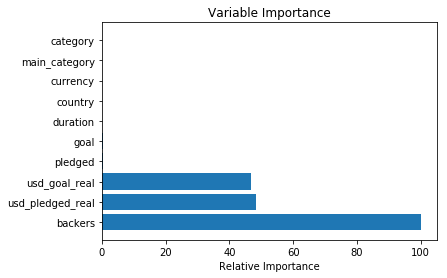

In [64]:
import matplotlib.pyplot as plt
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:10]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_ready.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Summary of Feature Importance
We can see the most important feature is backers, usd_pledged_real and usd_golad. These features make sense.
The more backers participate, the more project likely success.

---
<a id='step2'></a>
# Step2: Feature Engineering

- 2.1 Create Features
- 2.2 Convert Data Type
- 2.3 Split Data to Training and Testing
- 2.4 Scale Data
- 2.5 Pack Testing Data

## 2.1 Create Features 

Create duration as a new feature, add target value(if skip the Step 1) and alocate category feature as a list

In [3]:
# convert Datatiem, add duration

df['launched']= pd.to_datetime(df['launched'])
df['deadline']=pd.to_datetime(df['deadline'],format='%Y-%m-%d')
df['duration']=df['deadline'].dt.to_period("D")-df['launched'].dt.to_period("D")
# df['duration'D
df['duration']=df['duration'].astype(int)


#add the target to df
df['target']=df['state'].apply(lambda x: 1 if x=='successful' else 0)

# df_cat=df.select_dtypes(include=['object']).copy()
category_fea=['category', 'main_category', 'currency', 'country']

## 2.2 Convert Data Type

Convert categorical data from string to numerical type by `preprocessing.LabelEncoder`

In [4]:
# convert category variable to numeric
for column in ['category', 'main_category', 'currency', 'country']:
    le = preprocessing.LabelEncoder()
    le.fit(df[column])
    df[column]=le.transform(df[column])
    

## 2.3 Split Data to Training and Testing

* Apply `random.shuffle` to shake the data to prevent the situation that data originally come with the certain order
* Use `train_test_split` to split data, 80% for training and 20% for testing
* Extract Category data from train and testing because I want to train them in a particular way


In [5]:
# randomly split data
df=shuffle(df, random_state=777)

X=df.drop(['ID','name','target','state','usd pledged','deadline','launched'],axis=1)
y=df.target.copy()

#split training and testing with 80% and 20% of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)
y_train, y_test = y_train.values, y_test.values

(302928, 10) (75733, 10)


In [6]:
#Split category data from the main training and testing set.
X_train_cat=X_train[category_fea].copy().values
X_test_cat=X_test[category_fea].copy().values
X_train=X_train.drop(category_fea,axis=1)
X_test=X_test.drop(category_fea,axis=1)

## 2.4. Scale Data and Convert to Array 

Apply `StandardScaler` to nomalize training and testing data

In [7]:
#Scale Data and convert to array

all_data= np.vstack([X_train.values,X_test.values])
scaler = StandardScaler()
scaler.fit(all_data)
X_train= scaler.transform(X_train.values)
X_test = scaler.transform(X_test.values)

## 2.5. Pack Testing Data
In the future training, I will train categorical data with the embedding layer. (see the NN architecture in next step) 
The blow processing is to resemble the testing data. 
The training data will resemble after we use cross-validation method

In [8]:
#find the maximum value in each category feature or find the total number of elements in each categorical feature
#this is for embedding layer
max_cat_values=[np.max(X_train_cat[:,columns]) for columns in range(X_train_cat.shape[1])]
X_test_cat_list=[]
tem=X_test_cat
for i in range(X_test_cat.shape[1]):
    X_test_cat_list.append(tem[:,i].reshape(-1,1))
X_test_cat_list.append(X_test)


---
<a id='step3'></a>
# Step3: Create a NN Model with Keras

3.1. Define a Custom Metrics 
3.2. NN Model Set up
3.3. Training Model
3.4. Training Log Visualization: F1 scores and Loss

## 3.1. Define a Custom Metrics
The following custom metrics is from [Paddy](https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras) at stackoverflow.com, whcih calculates f1 scores during training in every epoch

In [9]:
# apply f1 socrses

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



## 3.2. NN Model Set up
### The Neural Network architecture
The following picture shows my idea of the NN structure. I train the categorical feature individually with an embedding layer, then merge with other numerical features following by two dense layers  

<img src="NNstructure.png">

In the NN model, I apply `Dropout` to reduce the overfitting and activated function `PReLU` for advance processing, and `BatchNormalization` to reduce the chance of gradient exploding. The last activated function is `sigmoid` because this project is two classes problem. For multiple classes, the `softmax` activated function could be a suitable activated function.

In [10]:
def nn_model():
    inputs = []
    flatten_layers = []
    
    #embedding layer
    for e, c in enumerate(category_fea):
        input_c = Input(shape=(1, ), dtype='int32')
        num_c = max_cat_values[e]
        
        # need to add 1, https://keras.io/layers/embeddings/
        # **input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.**
        embed_c = Embedding(num_c+1,6,input_length=1)(input_c)
        embed_c = Dropout(0.25)(embed_c)
        flatten_c = Flatten()(embed_c)
        inputs.append(input_c)
        flatten_layers.append(flatten_c)
        
    
    input_num = Input(shape=(X_train.shape[1],), dtype='float32')
    inputs.append(input_num)
    
    #merge X and embedding layer
    flatten_layers.append(input_num)
    flatten = concatenate(flatten_layers, axis=-1)

    #first dense layer
    fc1 = Dense(512, kernel_initializer='he_normal')(flatten)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.75)(fc1)

    #second dense layer
    fc1 = Dense(64, kernel_initializer='he_normal')(fc1)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.5)(fc1)

    outputs = Dense(1, kernel_initializer='he_normal', activation='sigmoid')(fc1)

    model = Model(inputs = inputs, outputs = outputs)
#     model.summary()
    
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[f1])
    return (model)

## 3.3. Training Model

Here I create five folds cross-validation. 
Because the data samples are big enough, let each training model as a weaker. 
In the final, I would find the average of the probability of success for each Kickstarter project from those weakers. 

This model will return the probability of success for each Kickstarter project base on the testing dataset `X_test_cat_list`, which we packed in step 2.5.
So each weaker will generate the probability then add up into `cv_pred`, which dividing by the number of weakers is the average of the probability.


In [14]:
NFOLDS=5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)


# cv_train = np.zeros(len(y_train))
cv_pred = np.zeros(len(y_test))

n =1

accuracy_list=[]

train_hist=defaultdict(dict)
for (train_index, valid_index) in kfold.split(X_train, y_train):
    
    if n==1:
        print('number of training data:',len(train_index), 
             '\nnumber of validation data: ',len(valid_index),
             '\nOriginal training data: ',X_train.shape[0])
    
    #the following 4 step is to load and resemble training and validating data
    #numerical data
    x       = X_train[train_index]
    y       = y_train[train_index]
    x_valid = X_train[valid_index]
    y_valid = y_train[valid_index]

    #categorical data ['category', 'main_category', 'currency', 'country']
    x_cat=X_train_cat[train_index]
    x_valid_cat=X_train_cat[valid_index]
    
    
    # seperate categorical data for training with embedding layer
    x_list, x_valid_list= [],[]
    for i in range(X_train_cat.shape[1]):
            x_list.append(x_cat[:, i].reshape(-1, 1))
            x_valid_list.append(x_valid_cat[:, i].reshape(-1, 1))
            
    # merge numerical and categorical data
    x_list.append(x)
    x_valid_list.append(x_valid)
    
    #model
    model = nn_model()
    
    #training
    history_callback=model.fit(x_list, y, epochs=10, batch_size=512, verbose=2, validation_data=[x_valid_list, y_valid])
    
    #saving model
    model_name='valid_model_{0}.h5'.format(n)
    model.save(model_name)
    
    #recode training scores 
    train_hist['valid_{0}'.format(n)]=history_callback.history
    
    
#     cv_train[valid_index]+= model.predict(x=x_valid_list, batch_size=512,verbose=0)[:, 0]

    #training date to see the loss and accurcy 
#     loss_train, accuracy_train = model.evaluate(x_list, y)

    #save predictin from weakers for finial voting
    cv_pred+=model.predict(x=X_test_cat_list, batch_size=512, verbose=0)[:,0]
    
    # performance of the model traind with vaildation by testing data
    loss, accuracy = model.evaluate(X_test_cat_list, y_test)
    accuracy_list.append(accuracy*100)
    print("\nLoss: %.2f, Accuracy: %.2f%% base on the testing data" % (loss, accuracy*100))
    

    n+=1


number of training data: 242341 
number of validation data:  60587 
Original training data:  302928
Train on 242341 samples, validate on 60587 samples
Epoch 1/10
 - 19s - loss: 0.3227 - f1: 0.8142 - val_loss: 0.3967 - val_f1: 0.4075
Epoch 2/10
 - 16s - loss: 0.1770 - f1: 0.9078 - val_loss: 0.2515 - val_f1: 0.8436
Epoch 3/10
 - 16s - loss: 0.1397 - f1: 0.9306 - val_loss: 0.1716 - val_f1: 0.9554
Epoch 4/10
 - 16s - loss: 0.1201 - f1: 0.9419 - val_loss: 0.1582 - val_f1: 0.9553
Epoch 5/10
 - 18s - loss: 0.1114 - f1: 0.9466 - val_loss: 0.1514 - val_f1: 0.9520
Epoch 6/10
 - 18s - loss: 0.1038 - f1: 0.9505 - val_loss: 0.1949 - val_f1: 0.9285
Epoch 7/10
 - 17s - loss: 0.0994 - f1: 0.9531 - val_loss: 0.1854 - val_f1: 0.9582
Epoch 8/10
 - 16s - loss: 0.0972 - f1: 0.9542 - val_loss: 0.2348 - val_f1: 0.9166
Epoch 9/10
 - 16s - loss: 0.0968 - f1: 0.9547 - val_loss: 0.1517 - val_f1: 0.9706
Epoch 10/10
 - 16s - loss: 0.0941 - f1: 0.9557 - val_loss: 0.1616 - val_f1: 0.9594
75733/75733 [===============

In [15]:
#Save training info to pickle

outfile = open('train_hist','wb')
pickle.dump(train_hist,outfile)
outfile.close()

## 3.4. Training Log Visualization: F1 scores and Loss
###  Visulize Training Log


5 weakers with ten epochs
Use `plotly` to plot f1 scores

In [16]:
#Training Log of F1 Scores
ten=np.arange(1,11)
traces=[]
for i in range(1,6):
    
    y=train_hist['valid_%s'%i]['f1']
    
    trace=go.Scatter(
        x = ten,
        y = y,
        name = 'Weaker %s'%i,
        line = dict(
            width = 4)
        )
    traces.append(trace)

layout = dict(title = 'Training Log of F1',
              xaxis = dict(title = 'Epoch',dtick=1),
              yaxis = dict(title = 'F1 Scores'),
              )

fig = dict(data=traces, layout=layout)
iplot(fig, filename='styled-line')

We can see the that each epoch increases F1 scores. The training processing after epoch 3 grows slowly.

In [17]:
#Training Log of Loss
ten=np.arange(1,11)
traces=[]
for i in range(1,6):
    
    y=train_hist['valid_%s'%i]['loss']
    
    trace=go.Scatter(
        x = ten,
        y = y,
        name = 'Weaker %s'%i,
        line = dict(
            width = 4)
        )
    traces.append(trace)

layout = dict(title = 'Training Log of Loss',
              xaxis = dict(title = 'Epoch',dtick=1),
              yaxis = dict(title = 'Loss Scores'),
              )

fig = dict(data=traces, layout=layout)
iplot(fig, filename='styled-line')


We can see the that each epoch reduce loss. The difference between each weaker are very subtle, indicating the variance of the model is very low

---
<a id='step4'></a>
# Step4: Model Evaluation

* 4.1 Load Model
* 4.2 ROC Curve
* 4.3 Final Scores

## 4.1. Load Model

If you don't want to train model again, run the load model section with the hdf5 files

In [138]:
#load model
models=[]
cv_pred = np.zeros(len(y_test))
for i in range(1,6):
    model=load_model('valid_model_{0}.h5'.format(i), custom_objects={'f1': f1})
    models.append(model)
    cv_pred+=model.predict(x=X_test_cat_list, batch_size=512, verbose=0)[:,0]
    
    
#load training info
# open a file, where you stored the pickled data
file = open('train_hist', 'rb')

# dump information to that file
train_hist = pickle.load(file)

# close the file
file.close()

In [19]:
#outcome as probabilty
#the finial prediciton of the probabilty
final_cv_pred=cv_pred/5
#for ROC curve
fpr, tpr, _ = roc_curve(y_test, final_cv_pred)
roc_auc = auc(fpr, tpr)

## 4.2. ROC curve
Use ROC curve to evaluate the model ability to separate the classes

In [20]:
trace1 = go.Scatter(x=fpr, y=tpr, 
                    mode='lines', 
                    line=dict(color='darkorange', width=2),
                    name='ROC curve (area = %0.2f)' % roc_auc
                   )

trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                    mode='lines', 
                    line=dict(color='navy', width=2, dash='dash'),
                    showlegend=False)

layout = go.Layout(title='Receiver operating characteristic(ROC)',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=[trace1,trace2], layout=layout)
iplot(fig)

The area blew the curve shows 1, which indicates that our model separates the classes, success and non-success, properly.

## 4.3 Final Scores

I apply `output_classifer` to predict the classes for each instance base on the probability of success of each instance. Then, use the class `predicted_class` to find the f1_score and accuracy comparing with groud true `y_test`

In [24]:
# This function convert the probablity to the class 0 or 1.
#output as classifier 
def output_classifer(prob_array):
    prediction=np.zeros(len(prob_array))
    for i in range(len(prob_array)):
        prediction[i]+=np.random.choice([0,1],1,p=[1-prob_array[i],prob_array[i]])
    return prediction

predicted_class=output_classifer(final_cv_pred)

In [25]:
print('Classes Prediction')
print('\nF1 Score: ',round(f1_score(y_test,predicted_class),2))
print('Accurcay: {0}% '.format(round((accuracy_score(y_test,predicted_class)*100),2)))


Classes Prediction

F1 Score:  0.83
Accurcay: 87.9% 


The cells below shows the Average accuracy base on the probability that each weaker product from `y_test`

In [21]:
print('Probability of Classes')
print('Average accuracy from weakers: {0}%'.format(round(np.mean(accuracy_list),2)))

Probability of Classes
Average accuracy from weakers: 95.79%


---

<a id='Conclusion'></a>
# Conclusion

There are also several methods I can apply to improve this project. For example, use the most important features to train the model in the way I do for categorical features.
Applying some feature engineering methods, like feature aggregation and target encoding, and trying different algorithms, like gradient boost tree, XGboost or LightGBM, may give us different performance. I satisfy my result, but there is no best algorithm or model for the problem unless I try different algorithms. 